### gaficos para analisar distribuiçãoes - DEtação data drift

- Histograma
- Grafico de Densidade
- Grafico Q-Q (Quantile-Quantile) 

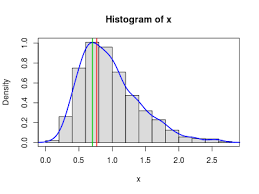{width=30 height=30}
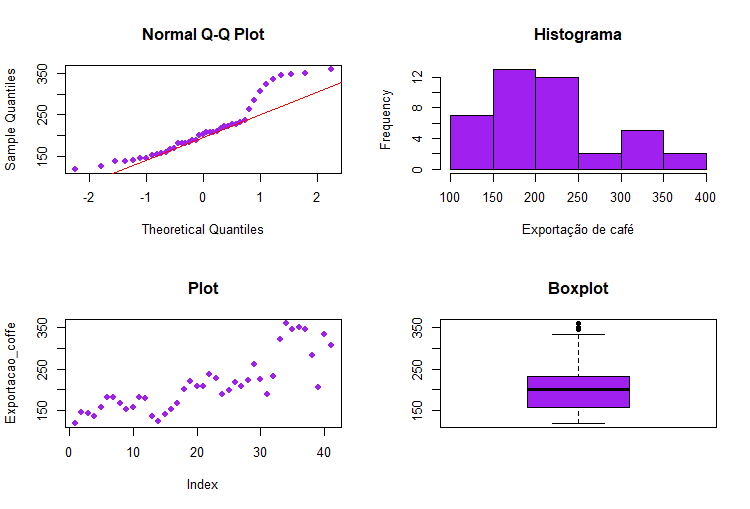

### Tecnicas de comparação de distribuiçãoes

In [19]:
import numpy as np
import matplotlib.pyplot as plt

Kolmogorov-Smirnov (KS):

O KS compara duas distribuições de probabilidade acumulada.
A estatística KS (D) é calculada como a maior diferença vertical entre as duas distribuições acumuladas.
A fórmula para calcular a estatística KS é:
![image.png](attachment:image.png)

Population Stability Index (PSI):

O PSI compara a distribuição de pontuações entre duas populações.
O PSI é calculado usando a fórmula:
![image-2.png](attachment:image-2.png)


- O **PSI** é adequado para variáveis ​​alvo contínuas e enfatiza a similaridade em toda a distribuição.
- O **KS** se concentra na discrepância máxima entre as distribuições cumulativas.
- O Coeficiente de **Gini** se aplica especificamente a problemas de classificação e avalia a qualidade da separação de classes.

In [20]:
## Calculando a metrica PSI

def calcular_psi(populacao_desenvolvimento, populacao_producao, num_blocos=10):
    # Dividir as pontuações em intervalos
    intervalos = np.linspace(0, 1, num_blocos + 1)
    
    # Calcular as proporções de cada intervalo de pontuação para ambas as populações
    proporcoes_d = np.histogram(populacao_desenvolvimento, bins=intervalos)[0] / len(populacao_desenvolvimento)
    proporcoes_p = np.histogram(populacao_producao, bins=intervalos)[0] / len(populacao_producao)
    
    # Calcular o PSI usando a fórmula
    psi = np.sum((proporcoes_d - proporcoes_p) * np.log(proporcoes_d / proporcoes_p))
    
    return psi

# Exemplo de uso:
populacao_desenvolvimento = np.random.rand(1000)  # Pontuações da população de desenvolvimento
populacao_producao = np.random.rand(1000)  # Pontuações da população de produção

psi = calcular_psi(populacao_desenvolvimento, populacao_producao)
print("PSI:", psi)

PSI: 0.030090373971685392


In [9]:
populacao_producao.max()

0.9995238849027815

In [10]:
populacao_producao.min()

0.0016158114650007827

In [11]:
# Criação de intervalos de 0 a 1 com 10 blocos +1
num_blocos=10
intervalos = np.linspace(0, 1, num_blocos + 1)
intervalos

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [12]:
# Calcular as proporções de cada intervalo de pontuação para ambas as populações
proporcoes_d = np.histogram(populacao_desenvolvimento, bins=intervalos)[0] / len(populacao_desenvolvimento)
proporcoes_p = np.histogram(populacao_producao, bins=intervalos)[0] / len(populacao_producao)

(array([2.0000e+00, 2.1000e+01, 5.1000e+01, 2.3500e+02, 7.8100e+02,
        2.1000e+03, 4.5730e+03, 8.3390e+03, 1.2758e+04, 1.6363e+04,
        1.7345e+04, 1.4923e+04, 1.0920e+04, 6.4830e+03, 3.1070e+03,
        1.3810e+03, 4.5300e+02, 1.2200e+02, 3.6000e+01, 7.0000e+00]),
 array([3.20889223, 3.38336526, 3.55783829, 3.73231132, 3.90678435,
        4.08125738, 4.25573041, 4.43020344, 4.60467647, 4.7791495 ,
        4.95362253, 5.12809556, 5.30256859, 5.47704162, 5.65151465,
        5.82598768, 6.00046071, 6.17493374, 6.34940677, 6.5238798 ,
        6.69835283]),
 <BarContainer object of 20 artists>)

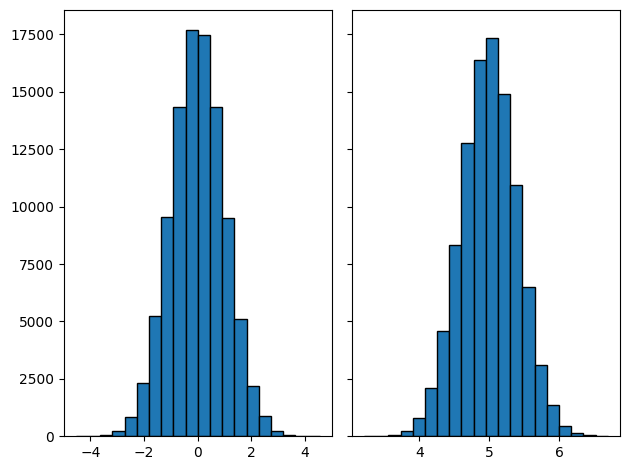

In [16]:
rng = np.random.default_rng(19680801)

N_points = 100000
n_bins = 20

# Generate two normal distributions
dist1 = rng.standard_normal(N_points)
dist2 = 0.4 * rng.standard_normal(N_points) + 5

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(dist1, bins=n_bins, edgecolor='black')
axs[1].hist(dist2, bins=n_bins, edgecolor='black')

In [22]:
# Calcular o PSI
import numpy as np
import pandas as pd

def calculate_psi(expected, actual, bins=10):
    # Calcula os intervalos de pontuação
    bins = np.percentile(expected, np.linspace(0, 100, bins+1))
    
    # Divide as pontuações em intervalos
    expected_bins = np.digitize(expected, bins)
    actual_bins = np.digitize(actual, bins)
    
    # Calcula a proporção de observações em cada intervalo para as duas populações
    expected_props = pd.Series(expected_bins).value_counts(normalize=True).sort_index()
    actual_props = pd.Series(actual_bins).value_counts(normalize=True).sort_index()
    
    # Calcula o PSI
    psi = ((actual_props - expected_props) * np.log(actual_props / expected_props)).sum()
    
    return psi

# Exemplo de uso:
expected_scores = np.random.rand(1000)
actual_scores = np.random.rand(1000)

psi = calculate_psi(expected_scores, actual_scores)
print("PSI:", psi)

# A maior PSI, maior deferença entre as distribuições

PSI: 0.03248009673128175


In [31]:
import numpy as np

def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables

    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal

    Returns:
       psi_values: ndarray of psi values for each variable
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable

        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into

        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])

        expected_fractions = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_fractions = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = sum(sub_psi(expected_fractions[i], actual_fractions[i]) for i in range(0, len(expected_fractions)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[1 - axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [32]:
import pandas as pd
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'

# Importando o conjunto de dados
df = pd.read_csv(url)
df = df.rename(columns={'Survived': 'Target'})
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin','Sex', 'Embarked'])
df.shape

(891, 6)

In [37]:
import pandas as pd
psi_values = calculate_psi(expected=df.iloc[:100].values, 
              actual=df.iloc[100:200].values, 
              buckettype='bins', buckets=10, 
              axis=0)

# Add column names to the output array
output_array = np.column_stack((df.columns, psi_values.round(4)))

# Convert the output array into a DataFrame
df_output = pd.DataFrame(output_array, columns=['Columns', 'PSI Values'])

df_output['signification'] = df_output['PSI Values'].apply(lambda x: 'High Change' if float(x) >= 0.2 else ('Medium Change' if float(x) > 0.1 else 'Low Change'))
df_output

,Columns,PSI Values,signification
0,Target,0.0755,Low Change
1,Pclass,0.0069,Low Change
2,Age,0.0044,Low Change
3,SibSp,0.2374,High Change
4,Parch,0.2524,High Change
5,Fare,0.016,Low Change


In [21]:
#Calcular o KS
import numpy as np
from scipy.stats import ks_2samp

# Suponha que você tenha duas séries de pontuações: prev_0 e prev_1
prev_0 = np.random.normal(loc=0, scale=1, size=1000)
prev_1 = np.random.normal(loc=1, scale=1, size=1000)

# Calcular o teste KS entre as duas séries de pontuações
ks_stat, p_value = ks_2samp(prev_0, prev_1)

print("Estatística KS:", ks_stat)
print("Valor de p:", p_value)
#a maior ks stat, maior a diferença entre as duas distribuições

Estatística KS: 0.418
Valor de p: 1.2040448267583641e-78


In [ ]:
ks_stat, p_value = ks_2samp(prev_0, prev_1)

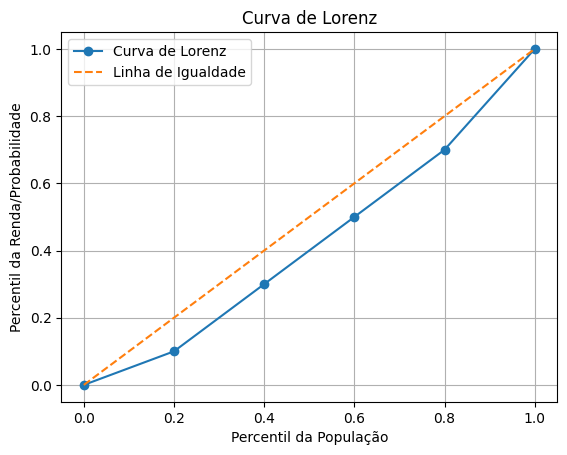

In [23]:
# Exemplo de indice de GINI com a cuva lorenz como base 

import numpy as np
import matplotlib.pyplot as plt

# Distribuição de probabilidade acumulada hipotética
L = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])  # Pontos x
probabilidade = np.array([0, 0.1, 0.3, 0.5, 0.7, 1.0])  # Pontos y

# Calcular a linha de igualdade (y = x)
linha_igualdade = np.linspace(0, 1, len(L))

# Plotar a curva de Lorenz
plt.plot(L, probabilidade, label='Curva de Lorenz', marker='o')
plt.plot(L, linha_igualdade, label='Linha de Igualdade', linestyle='--')

# Adicionar rótulos e título
plt.xlabel('Percentil da População')
plt.ylabel('Percentil da Renda/Probabilidade')
plt.title('Curva de Lorenz')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()